In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
import voxelmorph as vxm
from voxelmorph.tf.layers import SpatialTransformer
import nibabel as nib
import numpy as np

# Paths
MODEL_PATH = "/home/j/FPGA-project/voxelmorph/vxm_dense_brain_T1_3D_mse.h5"
ATLAS_NPZ = "/home/j/FPGA-project/voxelmorph/data/generated_uncond_atlas.npz"  # shipped in repo


2025-05-11 15:28:52.748492: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-11 15:28:52.773995: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-11 15:28:52.774026: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-11 15:28:52.774044: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-11 15:28:52.780831: I tensorflow/core/platform/cpu_feature_g

In [2]:
import numpy as np

# Load your .npz file
npzfile = np.load("/home/j/FPGA-project/voxelmorph/data/generated_uncond_atlas.npz")

# See what keys it actually contains
print("Archive keys:", npzfile.files)
# → e.g. ['arr_0']

# Extract the only array (usually under 'arr_0')
key   = npzfile.files[0]
atlas = npzfile[key]
print("Atlas shape:", atlas.shape)  # should be (160, 192, 224)

Archive keys: ['vol']
Atlas shape: (160, 192, 224)


In [3]:
np.save("data/generated_uncond_atlas.npy", atlas)

In [4]:
atlas = np.load("data/generated_uncond_atlas.npy")

In [5]:
model = vxm.networks.VxmDense.load(
    MODEL_PATH,
    inshape=atlas.shape,       
    input_model=None           
)
model 

2025-05-11 15:28:54.541993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-11 15:28:54.573995: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/voxelmorph/tf/networks.py:124: UserWarning: int_downsize is deprecated, use the int_resolution parameter.
  warnings.warn('int_downsize is deprecated, use the int_resolution parameter.')
/home/j/miniconda3/envs/gen/lib/python3.10/site-packages/voxelmorph/tf/networks.py:129: UserWarning: unet_half_res is deprec

In [6]:
rng   = np.random.RandomState(42)
moving = np.clip(atlas + rng.normal(0,0.1,atlas.shape), 0, 1)

In [7]:
fixed_norm  = (atlas  - atlas.min())  / (atlas.max()  - atlas.min())
moving_norm = (moving - moving.min()) / (moving.max() - moving.min())

In [8]:
fx_in = fixed_norm[np.newaxis, ..., np.newaxis]
mv_in = moving_norm[np.newaxis,..., np.newaxis]

In [9]:
flow = model.register(mv_in, fx_in)

1/1 [==============================] - 2s 2s/step


In [10]:
transform = vxm.networks.Transform(atlas.shape, nb_feats=1)
warped   = transform.predict([mv_in, flow])[0, ..., 0]  

1/1 [==============================] - 0s 419ms/step


In [11]:
nib.Nifti1Image(warped,  np.eye(4)).to_filename("warped_output.nii.gz")
nib.Nifti1Image(flow,    np.eye(4)).to_filename("flow_field.nii.gz")

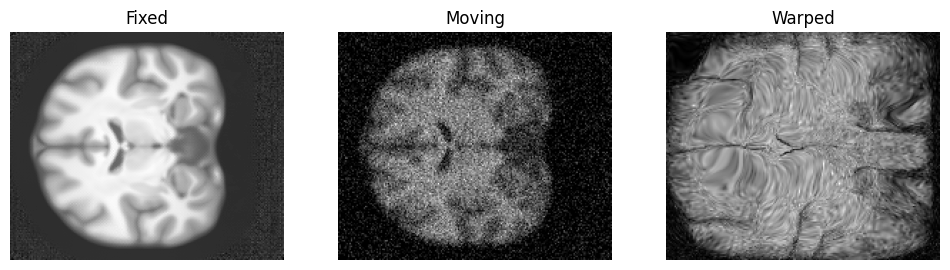

In [12]:
import matplotlib.pyplot as plt

z = atlas.shape[2] // 2
plt.figure(figsize=(12,4))
for i,(vol,title) in enumerate([(atlas,"Fixed"), (moving,"Moving"), (warped,"Warped")]):
    plt.subplot(1,3,i+1)
    plt.imshow(vol[...,z], cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.show()


In [ ]:
# ─── Cell: Export VxmDense model to ONNX ───────────────────────────────────
import tensorflow as tf
import tf2onnx
import voxelmorph as vxm

model = vxm.networks.VxmDense.load(
    MODEL_PATH,
    inshape=atlas.shape,    
    input_model=None
)

batch = 1
inshape = atlas.shape + (1,)  
spec = [
    tf.TensorSpec((batch,)+inshape, tf.float32, name="moving"),
    tf.TensorSpec((batch,)+inshape, tf.float32, name="fixed"),
]

onnx_model, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=13,
    output_path="vxm_dense_brain_T1_3D_mse.onnx"
)

print("ONNX model saved as vxm_dense_brain_T1_3D_mse.onnx")



2025-05-11 15:31:18.533222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-11 15:31:18.533264: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-05-11 15:31:18.533602: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-05-11 15:31:18.533924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-11 15:31:18.533954: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/

ONNX model saved as vxm_dense_brain_T1_3D_mse.onnx


In [18]:
import onnxruntime as ort
sess = ort.InferenceSession("vxm_dense_brain_T1_3D_mse.onnx")
print("Inputs:", [(i.name, i.shape) for i in sess.get_inputs()])
print("Outputs:", [(o.name, o.shape) for o in sess.get_outputs()])


Inputs: [('moving', [1, 160, 192, 224, 1]), ('fixed', [1, 160, 192, 224, 1])]
Outputs: [('vxm_dense_transformer', [1, 160, 192, 224, 1]), ('vxm_dense_flow', [1, 80, 96, 112, 3])]
